In [1]:
from torch.utils.data import Dataset
import torchvision
from PIL import Image
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
import torch

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
COLAB = 'google.colab' in str(get_ipython())

if COLAB: # running on Colab
    
    from google.colab import drive
    drive.mount('/content/drive')
    gdrive_path = '/content/drive//MyDrive/DL4CV-2022/project-I/'
    sys.path.append(gdrive_path)
    
    import utils.helpers as utils
    import loader.gtsrb_data as dataset

    try:
        GTSRB_train_dataset = dataset.GTSRB(gdrive_path+'data/')
    except OSError:
        GTSRB_train_dataset = dataset.GTSRB(gdrive_path+'data/')
        assert len(GTSRB_train_dataset) == 39209

    GTSRB_train_dataloader = torch.utils.data.DataLoader(GTSRB_train_dataset, 
                                              batch_size=128, 
                                              shuffle=True, num_workers=2)
else:
    path = 'data'
    import utils.helpers as utils
    import loader.gtsrb_data as dataset
    GTSRB_train_dataset = dataset.GTSRB('data/')
    assert len(GTSRB_train_dataset) == 39209
    
    GTSRB_train_dataloader = torch.utils.data.DataLoader(
                            GTSRB_train_dataset, 
                            batch_size=128, 
                            shuffle=True, num_workers=2)

In [4]:
if COLAB:
    sign_names = utils.make_class_dict(gdrive_path + 'data/signnames.csv')
else:
    sign_names = utils.make_class_dict('data/signnames.csv')

classes = list(sign_names.values())

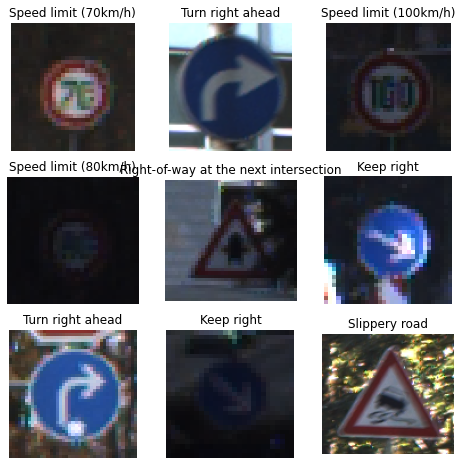

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(GTSRB_train_dataset), size=(1,)).item()
    img, label, frame = GTSRB_train_dataset[sample_idx]    
    figure.add_subplot(rows, cols, i)
    plt.title(sign_names[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()


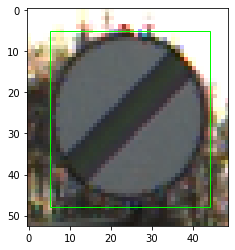

In [6]:
sample_idx = torch.randint(len(GTSRB_train_dataset), size=(1,)).item()
img, label, frame = GTSRB_train_dataset[sample_idx]
img_frame = list(frame.items())
utils.show_framed_img(img, img_frame)

In [ ]:
''' GUTTER

# for automatic reloading and inline matplotlib
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#from sklearn.metrics import confusion_matrix

from PIL import Image

print (len(trainLabels), len(trainImages))



import utils.helpers as utils
import loader.gtsrb_data as dataset
#GTSRB_train_dataset = dataset.GTSRB('./data/')
utils.compress_pickle('data/pbz2/GTSRB_train_dataloader', GTSRB_train_dataloader)
#GTSRB_train_dataset = utils.decompress_pickle('data/pbz2/GTSRB_train_dataset.pbz2')
#GTSRB_train_dataloader = torch.utils.data.DataLoader(GTSRB_train_dataset, 
                                          #batch_size=128, 
                                          #shuffle=True, num_workers=2)
                                          
                                          
class GTSRBLoader(torch.utils.data.Dataset):

    def __init__(self, data_dir, split, custom_transforms=None, list_dir=None,
                 out_name=False,  crop_size=None, num_classes=43, phase=None):
        
        self.data_dir = data_dir
        self.split = split
        self.phase = split if phase is None else phase
        self.crop_size = 32 if crop_size is None else crop_size
        self.out_name = out_name
        self.idx2label = idx2label
        self.classnames = classnames

        self.num_classes = num_classes
        self.mean = np.array([0.3337, 0.3064, 0.3171])
        self.std = np.array([0.2672, 0.2564, 0.2629])
        self.image_list, self.label_list = None, None
        self.read_lists()
        self.transforms = self.get_transforms(custom_transforms)


    def __getitem__(self, index):
        im = Image.open(f'{self.data_dir}/{self.image_list[index]}')
        data = [self.transforms(im)]
        data.append(self.label_list[index])
        if self.out_name:
            data.append(self.image_list[index])
        return tuple(data)


    def __len__(self):
        return len(self.image_list)


    def get_transforms(self, custom_transforms):
        if custom_transforms:
            return custom_transforms

        if 'train' == self.phase:
            return transforms.Compose([
                transforms.Resize((self.crop_size, self.crop_size)),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0),
                transforms.ToTensor(),
                transforms.Normalize(mean=self.mean, std=self.std),
            ]) 
        else: 
            return transforms.Compose([
                transforms.Resize((self.crop_size, self.crop_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=self.mean, std=self.std),
            ])   


    def read_lists(self):
        image_path = os.path.join(self.data_dir, self.split + '_images.txt')
        assert os.path.exists(image_path)
        self.image_list = [line.strip().split()[0] for line in open(image_path, 'r')]
        self.label_list = [int(line.strip().split()[1]) for line in open(image_path, 'r')]
        assert len(self.image_list) == len(self.label_list)

    
    # get raw image prior to normalization
    # expects input image as torch Tensor
    def unprocess_image(self, im, plot=False):
        im = im.squeeze().numpy().transpose((1, 2, 0))
        im = self.std * im + self.mean
        im = np.clip(im, 0, 1)
        im = im * 255
        im = Image.fromarray(im.astype(np.uint8))
        
        if plot:
            plt.imshow(im)
            plt.show()
        else:
            return im
  
    # de-center images and bring them back to their raw state
    def unprocess_batch(self, input):
        for i in range(input.size(1)):
            input[:,i,:,:] = self.std[i] * input[:,i,:,:]
            input[:,i,:,:] = input[:,i,:,:] + self.mean[i]
            input[:,i,:,:] = np.clip(input[:,i,:,:], 0, 1)

        return input
        
def show_framed_img(img, img_frame):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    rect = patches.Rectangle((img_frame[0][1],img_frame[1][1]),
                             img_frame[2][1]-img_frame[0][1],
                             img_frame[3][1]-img_frame[1][1],
                             linewidth=1, edgecolor='#00ff00',facecolor='none')
    ax.add_patch(rect)
    plt.show()
    
def load_transform(resize, crop):
    transform = transforms.Compose(
        [transforms.Resize([256, 256]),
         transforms.RandomCrop(224),
         #transforms.RandomHorizontalFlip(),
         transforms.ToTensor()])
    return transform 
    
'''